# System reliability analysis

In this example, we will demonstrate how to perform a reliability analysis of a system consisting of two components. We will analyze two system configurations:
* Parallel System: the system fails only when both components fail.
* Series System: the system fails when at least one of the components fails.

### Define Limit State Functions

First, we import the necessary classes:

In [72]:
from probabilistic_library import ReliabilityProject, ReliabilityMethod, DistributionType, CombineProject, CombinerMethod, CombineType, Stochast

We consider two elements, each described by the following limit state functions:

$Z_1 = 1.9 - (a+b)$

$Z_2 = 1.85 - (1.5 \cdot b + 0.5 \cdot c)$

In [73]:
from utils.models import linear_a_b, linear_b_c

Note that both functions share a common variable $b$.

We consider two system configurations:
* Parallel system: the system fails only when both $Z_1$ and $Z_2$ are less than zero.
* Series system: the system fails when either $Z_1$ or $Z_2$ is less than zero.

In the first case we want to calculate the probability $P(Z_1<0 \cap Z_2<0)$ and, in the second case, the probability $P(Z_1<0 \cup Z_2<0)$.

### Perform reliability calculations for each element

First, we perform the reliability analysis of the individual elements (described by the limit state functions). 

We create a reliability project `ReliabilityProject()`. We assume that variables $a$ and $b$ are uniformly distributed over the interval $[-1, 1]$. The variable $c$ is normally distributed with a `mean` of $0.1$ and a `deviation` of $0.8$. We use the First Order Reliability Method (`FORM`) to run the reliability analysis.

It is essential to define the limit state function model before specifying the random variables!

Using `project.run()` we execute the reliability analysis for one limit state function. The results are stored in `project.design_point`. To combine the results later, we store the outputs in separate objects (`dp_Z1` and `dp_Z2`).

In [74]:
project = ReliabilityProject()
project.settings.reliability_method = ReliabilityMethod.form
project.settings.relaxation_factor = 0.75
project.settings.maximum_iterations = 50
project.settings.epsilon_beta = 0.01

project.model = linear_a_b

project.variables["a"].distribution = DistributionType.uniform
project.variables["a"].minimum = -1
project.variables["a"].maximum = 1

project.variables["b"].distribution = DistributionType.uniform
project.variables["b"].minimum = -1
project.variables["b"].maximum = 1

project.run()
dp_Z1 = project.design_point
dp_Z1.identifier = "Z1"
dp_Z1.print()

project.model = linear_b_c

project.variables["c"].distribution = DistributionType.normal
project.variables["c"].mean = 0.1
project.variables["c"].deviation = 0.8

project.run()
dp_Z2 = project.design_point
dp_Z2.identifier = "Z2"
dp_Z2.print()

Reliability (Z1)
 Reliability index = 2.772
 Probability of failure = 0.002783
 Convergence = 0.004051 (converged)
 Model runs = 21
Alpha values:
 a: alpha = -0.7071, x = 0.95
 b: alpha = -0.7071, x = 0.95

Reliability (Z2)
 Reliability index = 1.95
 Probability of failure = 0.02559
 Convergence = 0.007929 (converged)
 Model runs = 18
Alpha values:
 b: alpha = -0.719, x = 0.8391
 c: alpha = -0.695, x = 1.184



### Perform reliability analysis of a system

To perform the reliability analysis of a system, we create a new project using `CombineProject()`. We append the reliability results of the individual elements to this object.

In [75]:
combine_project = CombineProject()

combine_project.design_points.append(dp_Z1)
combine_project.design_points.append(dp_Z2)

The library offers the following methods for the reliability analysis of a system: `hohenbichler`, `hohenbichler_form`, `importance_sampling`, `directional_sampling`. The desired reliability method can be set using `combine_project.settings.combiner_method`.

The type of system configuration (`series` or `parallel`) can be defined using `combine_project.combine_type`.

Execute the reliability analysis of the system using `combine_project.run()`. The results will be stored in `combine_project.design_point`.

In [76]:
def fault_tree(combine_project, combine_type):

    combine_algorithms = [CombinerMethod.hohenbichler, CombinerMethod.hohenbichler_form, CombinerMethod.importance_sampling, CombinerMethod.directional_sampling]

    combine_project.settings.combine_type = combine_type
    combine_algorithms = [CombinerMethod.hohenbichler, CombinerMethod.importance_sampling, CombinerMethod.directional_sampling]

    for combine_algorithm in combine_algorithms:

        combine_project.settings.combiner_method = combine_algorithm
        combine_project.run()
        dp = combine_project.design_point
        dp.identifier = str(combine_type) + ' - ' + str(combine_algorithm)
 
        dp.print()

fault_tree(combine_project, CombineType.series)
fault_tree(combine_project, CombineType.parallel)

Reliability (series - hohenbichler)
 Reliability index = 1.92
 Probability of failure = 0.02746
 Model runs = 0
Alpha values:
 a: alpha = -0.0725, x = 0.95
 b: alpha = -0.7507, x = 0.95
 c: alpha = -0.6567, x = 0

Contributing design points:
  Reliability (Z1)
   Reliability index = 2.772
   Probability of failure = 0.002783
   Convergence = 0.004051 (converged)
   Model runs = 21
  Alpha values:
   a: alpha = -0.7071, x = 0.95
   b: alpha = -0.7071, x = 0.95

  Reliability (Z2)
   Reliability index = 1.95
   Probability of failure = 0.02559
   Convergence = 0.007929 (converged)
   Model runs = 18
  Alpha values:
   b: alpha = -0.719, x = 0.8391
   c: alpha = -0.695, x = 1.184

Reliability (series - importance_sampling)
 Reliability index = 1.919
 Probability of failure = 0.02749
 Model runs = 0
Alpha values:
 a: alpha = -0.1006, x = 0.1531
 b: alpha = -0.7622, x = 0.8564
 c: alpha = -0.6395, x = 1.082

Contributing design points:
  Reliability (Z2)
   Reliability index = 1.95
   Proba

### Uncorrelated $b$ variable

In the previous calculations, the variable $b$ in the limit state function $Z_1$​ was assumed to be the same as the variable $b$ in the limit state function $Z_2$​, implying a perfect correlation (correlation coefficient of $1.0$). This section demonstrates the impact of this assumption on the reliability analysis results.

To explore the effect of relaxing this assumption, we will now assume that the variable $b$ in $Z_1$ is not correlated with the variable $b$ in $Z_2$. Specifically, we set the correlation coefficient to $0.0$.

In [77]:
combine_project.correlation_matrix["b"] = 0.0

fault_tree(combine_project, CombineType.series)
fault_tree(combine_project, CombineType.parallel)

Reliability (series - hohenbichler)
 Reliability index = 1.906
 Probability of failure = 0.0283
 Model runs = 0
Alpha values:
 a: alpha = -0.09896, x = 0.95
 b: alpha = -0.7188, x = 0.95
 c: alpha = -0.6882, x = 0

Contributing design points:
  Reliability (Z1)
   Reliability index = 2.772
   Probability of failure = 0.002783
   Convergence = 0.004051 (converged)
   Model runs = 21
  Alpha values:
   a: alpha = -0.7071, x = 0.95
   b: alpha = -0.7071, x = 0.95

  Reliability (Z2)
   Reliability index = 1.95
   Probability of failure = 0.02559
   Convergence = 0.007929 (converged)
   Model runs = 18
  Alpha values:
   b: alpha = -0.719, x = 0.8391
   c: alpha = -0.695, x = 1.184

Reliability (series - importance_sampling)
 Reliability index = 1.907
 Probability of failure = 0.02827
 Model runs = 0
Alpha values:
 a: alpha = -0.1006, x = 0.1521
 b: alpha = -0.7622, x = 0.8539
 c: alpha = -0.6395, x = 1.076

Contributing design points:
  Reliability (Z2)
   Reliability index = 1.95
   Prob

Additionally, let’s plot the limit state functions ($Z = 0$):

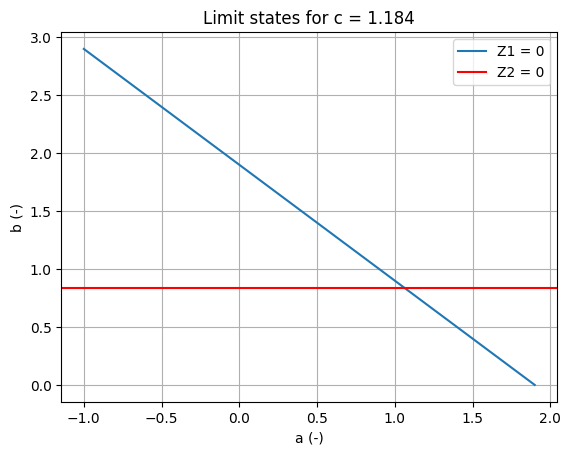

In [78]:
import matplotlib.pyplot as plt
import numpy as np

def linear_a_b_zero(a):
    b = 1.9 - a
    return b

def linear_b_c_zero(c):
    b = (1.85 - 0.5 * c) / 1.5
    return b

a = np.arange(-1.0, 2.0, 0.1)
c = [1.184]

b_z1 = [linear_a_b_zero(val) for val in a]
b_z2 = [linear_b_c_zero(val) for val in c]

plt.plot(a, b_z1, label='Z1 = 0')
plt.axhline(y=b_z2, color='r', label='Z2 = 0')
plt.grid()
plt.legend()
plt.xlabel('a (-)')
plt.ylabel('b (-)')
plt.title(f'Limit states for c = {c[0]}')
plt.show()
